# __Set Up & Import__

## Import Necessary Library

In [ ]:
# %pip install opencv-python
# %pip install mediapipe
# %pip install plotly
# %pip install pandas
# %pip install imageio


In [16]:
import cv2
import mediapipe as mp
import pandas as pd
import numpy as np
import plotly.express as px
import ast
import matplotlib.pyplot as plt
import os
import matplotlib.animation as animation
import imageio

## Set Color Class [ _Not Important_ ]

In [17]:
class color:
   PINK = '\033[95m'
   CYAN = '\033[96m'
   PURPLE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

## Set Up Detection Model

In [29]:
mp_holistic = mp.solutions.holistic
holistic_model = mp_holistic.Holistic(
    min_detection_confidence=0.1,
    min_tracking_confidence=0.1
)

# Initializing the drawing utils for drawing the landmarks on image
mp_drawing = mp.solutions.drawing_utils

I0000 00:00:1729331106.764921   66090 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M2


W0000 00:00:1729331106.902334   86994 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729331106.926623   86999 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729331106.930232   86997 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729331106.930364   86999 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729331106.931124   87000 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729331106.945238   87000 inference_feedback_manager.cc:114] Feedback manager 

# __Define Needed Function__

## Extract & Structerize Position From Each Part

In [18]:
def extract_data(hand_pos):
    right, left, body, i = dict(), dict(), dict(), 0
    if hand_pos[0] != None:
        for data in hand_pos[0].landmark:
            right['Landmark '+str(i)] = [data.x, data.y, data.z]
            i+=1
        i = 0
    else:
        right = None

    if hand_pos[1] != None:
        for data in hand_pos[1].landmark:
            left['Landmark '+str(i)] = [data.x, data.y, data.z]
            i+=1
        i = 0
    else:
        left = None

    if hand_pos[2] != None:
        for data in hand_pos[2].landmark:
            body['Landmark '+str(i)] = [data.x, data.y, data.z]
            i+=1
        i = 0
    else:
        body = None

    hand_pos = {'Right': right, 'Left': left, 'Body': body}
    hand_pos_df = pd.DataFrame(hand_pos).T
    
    return hand_pos_df

## Main Function

In [21]:
def operate(mp_holistic,holistic_model, mp_drawing, file,folder_path):    
    vid = cv2.VideoCapture(file)
    total_frame, total_capture = int(vid.get(cv2.CAP_PROP_FRAME_COUNT)), 0

    for i in range(total_frame):
        if i%(total_frame//30) == 0:
            total_capture+=1
        else:
            continue
        ret, frame = vid.read()

        vid.set(cv2.CAP_PROP_POS_FRAMES, (total_capture)*(total_frame/30))

        if not ret or cv2.waitKey(5) & 0xFF == ord('q'):
            break
        
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        image.flags.writeable = False
        results = holistic_model.process(image)
        image.flags.writeable = True
    
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Draw Pose And Face Land Marks 
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
        # Drawing Right hand Land Marks
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
        # Drawing Left hand Land Marks
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

        # Display the resulting image
        cv2.imshow("Display", image)

        left= results.left_hand_landmarks
        right = results.right_hand_landmarks
        upper = results.pose_landmarks
        hand_pos_df = extract_data([right, left, upper])
        hand_pos_df.to_csv(folder_path+'/Frame_'+str(total_capture-1)+'.csv')
        print("\r"+"Successfully captured frame:", color.RED+color.BOLD+str(total_capture)+color.END+" / 30", end="")
        # print("Successfully captured frame:", color.RED+color.BOLD+str(total_capture)+color.END+" / 30")

    vid.release()
    cv2.destroyAllWindows()
    print("\n"+color.BOLD+color.GREEN+"Done!"+color.END)

## Graph Drawing

In [22]:
edges = {
        "left_hand": [
            (0, 1), (1, 2), (2, 3), (3, 4), (0, 5), (0, 17), (5, 6), (6, 7),
            (7, 8), (5, 9), (9, 10), (10, 11), (11, 12), (9, 13), (13, 14),
            (14, 15), (15, 16), (13, 17), (17, 18), (18, 19), (19, 20)
        ],
        "right_hand": [
            (0, 1), (1, 2), (2, 3), (3, 4), (0, 5), (0, 17), (5, 6), (6, 7),
            (7, 8), (5, 9), (9, 10), (10, 11), (11, 12), (9, 13), (13, 14),
            (14, 15), (15, 16), (13, 17), (17, 18), (18, 19), (19, 20)
        ],
        "pose": [
            (8, 6), (6, 5), (6, 4), (4, 0), (0, 1), (1, 2), (2, 3), (3, 7),
            (10, 9), (11, 12), (11, 13), (11, 23), (13, 15), (15, 21), (15, 17),
            (15, 19), (17, 19), (12, 14), (12, 24), (14, 16), (16, 22), (16, 20),
            (16, 18), (18, 20), (23, 24)
        ],
    }

In [23]:
def draw_edges(ax, points, edges):
    
    for edge in edges:
        start, end = edge

        if start < len(points) and end < len(points):
            x_values = [points[start][0], points[end][0]]
            y_values = [points[start][1], points[end][1]]
            ax.plot(x_values, y_values, 'k-')

In [24]:
def graph_drawer(frame ,edges):
    # Extract data from the CSV file
    lst_frame_right = frame.iloc[0][1:].to_frame().dropna().values
    lst_frame_left = frame.iloc[1][1:].to_frame().dropna().values
    lst_frame_body = frame.iloc[2][1:].to_frame().dropna().values

    # Convert string representations of lists to actual lists
    lst_frame_right = [ast.literal_eval(lst_frame_right[i][0]) for i in range(len(lst_frame_right))]
    lst_frame_left = [ast.literal_eval(lst_frame_left[i][0]) for i in range(len(lst_frame_left))]
    lst_frame_body = [ast.literal_eval(lst_frame_body[i][0]) for i in range(len(lst_frame_body))]

    # Extract x and y coordinates
    right_x = [lst_frame_right[i][0] for i in range(len(lst_frame_right))]
    right_y = [lst_frame_right[i][1] for i in range(len(lst_frame_right))]
    left_x = [lst_frame_left[i][0] for i in range(len(lst_frame_left))]
    left_y = [lst_frame_left[i][1] for i in range(len(lst_frame_left))]
    body_x = [lst_frame_body[i][0] for i in range(len(lst_frame_body))]
    body_y = [lst_frame_body[i][1] for i in range(len(lst_frame_body))]

    # Create the plot
    _, axis = plt.subplots(2, 2, constrained_layout=True)
    axis[0, 0].scatter(right_x, right_y)
    axis[0, 0].set_title("Right hand")

    axis[0, 1].scatter(left_x, left_y)
    axis[0, 1].set_title("Left hand")

    axis[1, 0].scatter(body_x, body_y)
    axis[1, 0].set_title("Body")

    axis[1, 1].scatter(right_x, right_y)
    axis[1, 1].scatter(left_x, left_y)
    axis[1, 1].scatter(body_x, body_y)
    axis[1, 1].set_title("All")

    # Draw edges for right hand, left hand, body, entire body
    draw_edges(axis[0, 0], lst_frame_right, edges["right_hand"])
    draw_edges(axis[0, 1], lst_frame_left, edges["left_hand"])
    draw_edges(axis[1, 0], lst_frame_body, edges["pose"])
    draw_edges(axis[1, 1], lst_frame_right, edges["right_hand"])
    draw_edges(axis[1, 1], lst_frame_left, edges["left_hand"])
    draw_edges(axis[1, 1], lst_frame_body, edges["pose"])


    # axis[0,0].yaxis.set_inverted(True)
    # axis[0,1].yaxis.set_inverted(True)
    # axis[1,0].yaxis.set_inverted(True)
    # axis[1,1].yaxis.set_inverted(True)

    # Invert 
    for ax in axis.flatten():
        ax.yaxis.set_inverted(True)
    plt.show()

In [25]:
def graph_drawer_animate(frame ,edges,file):
    # Extract data from the CSV file
    lst_frame_right = frame.iloc[0][1:].to_frame().dropna().values
    lst_frame_left = frame.iloc[1][1:].to_frame().dropna().values
    lst_frame_body = frame.iloc[2][1:].to_frame().dropna().values

    # Convert string representations of lists to actual lists
    lst_frame_right = [ast.literal_eval(lst_frame_right[i][0]) for i in range(len(lst_frame_right))]
    lst_frame_left = [ast.literal_eval(lst_frame_left[i][0]) for i in range(len(lst_frame_left))]
    lst_frame_body = [ast.literal_eval(lst_frame_body[i][0]) for i in range(len(lst_frame_body))]

    # Extract x and y coordinates
    right_x = [lst_frame_right[i][0] for i in range(len(lst_frame_right))]
    right_y = [lst_frame_right[i][1] for i in range(len(lst_frame_right))]
    left_x = [lst_frame_left[i][0] for i in range(len(lst_frame_left))]
    left_y = [lst_frame_left[i][1] for i in range(len(lst_frame_left))]
    body_x = [lst_frame_body[i][0] for i in range(len(lst_frame_body))]
    body_y = [lst_frame_body[i][1] for i in range(len(lst_frame_body))]

    # Create the plot
    _, axis = plt.subplots(2, 2, constrained_layout=True)
    axis[0, 0].scatter(right_x, right_y)
    axis[0, 0].set_title("Right hand")

    axis[0, 1].scatter(left_x, left_y)
    axis[0, 1].set_title("Left hand")

    axis[1, 0].scatter(body_x, body_y)
    axis[1, 0].set_title("Body")

    axis[1, 1].scatter(right_x, right_y)
    axis[1, 1].scatter(left_x, left_y)
    axis[1, 1].scatter(body_x, body_y)
    axis[1, 1].set_title("All")

    # Draw edges for right hand, left hand, body, entire body
    draw_edges(axis[0, 0], lst_frame_right, edges["right_hand"])
    draw_edges(axis[0, 1], lst_frame_left, edges["left_hand"])
    draw_edges(axis[1, 0], lst_frame_body, edges["pose"])
    draw_edges(axis[1, 1], lst_frame_right, edges["right_hand"])
    draw_edges(axis[1, 1], lst_frame_left, edges["left_hand"])
    draw_edges(axis[1, 1], lst_frame_body, edges["pose"])


    # axis[0,0].yaxis.set_inverted(True)
    # axis[0,1].yaxis.set_inverted(True)
    # axis[1,0].yaxis.set_inverted(True)
    # axis[1,1].yaxis.set_inverted(True)

    # Invert 
    for ax in axis.flatten():
        ax.yaxis.set_inverted(True)
    # plt.show()

    img_path = f'plot_img/{file}_img.png'
    try:
        plt.savefig(img_path)
        plt.close()
        return img_path
    except Exception as e:
        print(f"Error saving image: {e}")
        return None

In [26]:
from IPython.display import Image, display 
def animation_plot(frame_folder, edges, gif_name='animation.gif'):
    files = os.listdir(frame_folder)
    sorted_files = sorted(files, key=lambda x: int(x.split('.')[0].split('_')[1]))

    # List to hold the file names of each frame
    frame_images = []

    for file in sorted_files:
        frame = pd.read_csv(os.path.join(frame_folder, file))
        img_path = graph_drawer_animate(frame, edges,file)
        if img_path is None:
            print(f"Failed to generate frame for file: {file}")
            continue  # Skip this iteration if img_path is None
        frame_images.append(img_path)

    # Create a GIF from the images
    if frame_images:  # Ensure there are images to create a GIF
        with imageio.get_writer(gif_name, mode='I', duration=0.5) as writer:
            for img_path in frame_images:
                image = imageio.imread(img_path)
                writer.append_data(image)

        print(f'GIF saved as {gif_name}')
        display(Image(filename=gif_name))
    else:
        print("No frames were generated, GIF not created.")


/var/folders/t_/x6hdnsfd5sq7sg9rvkbfth5h0000gn/T/ipykernel_1915/3906266605.py:21: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(img_path)


GIF saved as animation.gif


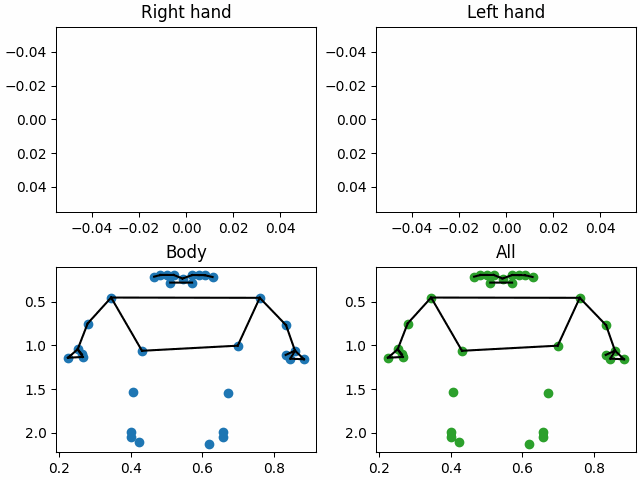

In [160]:
animation_plot("hello/1",edges)

# __KeyPoint__

In [154]:
operate(mp_holistic,holistic_model, mp_drawing, 'hello1.mp4',folder_path='hello/1')

/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData

Successfully captured frame: 3 / 30

/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData

Successfully captured frame: 6 / 30

/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData

Successfully captured frame: 9 / 30

/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData

Successfully captured frame: 12 / 30

/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData

Successfully captured frame: 15 / 30

/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData

Successfully captured frame: 18 / 30

/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData

Successfully captured frame: 21 / 30

/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData

Successfully captured frame: 24 / 30

/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData

Successfully captured frame: 27 / 30

/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData

Successfully captured frame: 30 / 30
Done!


# __Plot__

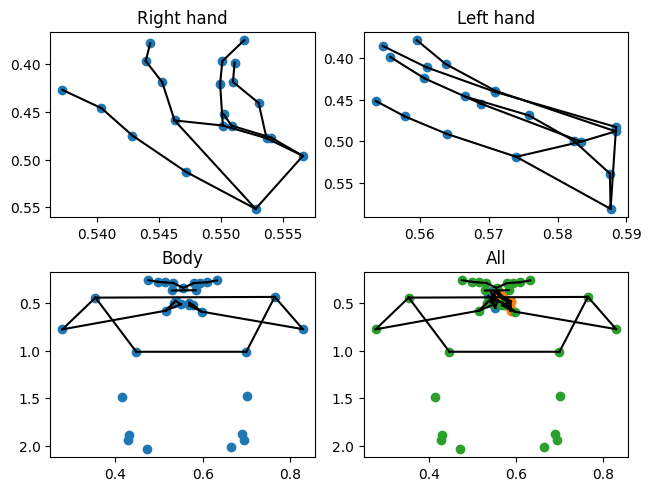

In [159]:
graph_drawer(pd.read_csv("hello/1/Frame_12.csv"), edges)

# __Keypoint Folder__

In [11]:
def operate2(mp_holistic,holistic_model, mp_drawing, file,folder_path,index):
    vdo_path = os.path.join(folder_path, file)
    os.mkdir('Landmarked/' + folder_path+'/'+str(index))
    vid = cv2.VideoCapture(vdo_path)
    total_frame, total_capture = int(vid.get(cv2.CAP_PROP_FRAME_COUNT)), 0

    for i in range(total_frame):
        if i%(total_frame//30) == 0:
            total_capture+=1
        else:
            continue
        ret, frame = vid.read()

        vid.set(cv2.CAP_PROP_POS_FRAMES, (total_capture)*(total_frame/30))

        if not ret or cv2.waitKey(5) & 0xFF == ord('q'):
            break
        
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        image.flags.writeable = False
        results = holistic_model.process(image)
        image.flags.writeable = True
    
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Draw Pose And Face Land Marks 
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
        # Drawing Right hand Land Marks
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
        # Drawing Left hand Land Marks
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

        # Display the resulting image
        cv2.imshow("Display", image)

        left= results.left_hand_landmarks
        right = results.right_hand_landmarks
        upper = results.pose_landmarks
        hand_pos_df = extract_data([right, left, upper])
        hand_pos_df.to_csv('Landmarked/'+folder_path + '/' +str(index) +'/Frame_'+str(total_capture-1)+'.csv')
        # print("\r"+"Successfully captured frame:", color.RED+color.BOLD+str(total_capture)+color.END+" / 30", end="")
        # print("Successfully captured frame:", color.RED+color.BOLD+str(total_capture)+color.END+" / 30")

    # vid.release()
    # cv2.destroyAllWindows()
    print("\n"+color.BOLD+color.GREEN+"Done!"+color.END)

In [12]:
def landmark_folder(folder_path):
    files = os.listdir(folder_path)
    os.mkdir('Landmarked/' + folder_path)
    for index,file in enumerate(files):
        operate2(mp_holistic,holistic_model, mp_drawing, file,folder_path,index)
    print("เสร็จหมดละจ้าา")

In [28]:
landmark_folder("บ้าน_test")

W0000 00:00:1729329751.029346   67320 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_


Done!


/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData


Done!


/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData


Done!


/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData


Done!


/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData


Done!


/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData


Done!


/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData


Done!


/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData


Done!


/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData


Done!


/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData


Done!


/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData


Done!


/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData


Done!


/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData


Done!


/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData


Done!
เสร็จหมดละจ้าา
